In [1]:
import pickle
import os
import matplotlib.pyplot as plt
import pandas as pd
from prepare_data import clean_string, split_by_name, create_triplet_samples, resolve_name_mismatches, reconcile_names
from dataset import VoiceFaceDataset
import numpy as np

In [1]:
%run download_data.py


/Users/dimarudman/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1HAk0yiiCKUT47i6l6kTW7Z3yovYCBdJW
From (redirected): https://drive.google.com/uc?id=1HAk0yiiCKUT47i6l6kTW7Z3yovYCBdJW&confirm=t&uuid=7382b779-94f6-4bf9-ae32-90ff963a059d
To: /Users/dimarudman/Voice-Face-matching/vfm_assignment.zip
100%|██████████| 1.19G/1.19G [00:52<00:00, 22.5MB/s]


Unzipping vfm_assignment.zip to vfm_assignment
Download and extraction complete. Data available in vfm_assignment
Contents of vfm_assignment: ['images', 'audio', 'audio_embeddings.pickle', 'image_embeddings.pickle']


In [2]:
# Define the path to the dataset
base_path = 'vfm_assignment'  # Adjust this path according to your environment

# Load image embeddings
with open(os.path.join(base_path, 'image_embeddings.pickle'), 'rb') as f:
    image_embeddings = pickle.load(f)

# Load audio embeddings
with open(os.path.join(base_path, 'audio_embeddings.pickle'), 'rb') as f:
    audio_embeddings = pickle.load(f)

# Display the type and length of the embeddings
print('Image embeddings:')
print(f'Type: {type(image_embeddings)}, Length: {len(image_embeddings)}')
print('Audio embeddings:')
print(f'Type: {type(audio_embeddings)}, Length: {len(audio_embeddings)}')


Image embeddings:
Type: <class 'dict'>, Length: 7129
Audio embeddings:
Type: <class 'dict'>, Length: 32090


In [3]:
# Example to check dimensions of embeddings
image_example = next(iter(image_embeddings.values()))
audio_example = next(iter(audio_embeddings.values()))

print(f'Dimensions of an image embedding vector: {image_example.shape}')
print(f'Dimensions of an audio embedding vector: {audio_example.shape}')

# Optionally, display keys to understand naming conventions
print("Example keys (image):", list(image_embeddings.keys())[:3])
print("Example keys (audio):", list(audio_embeddings.keys())[:3])

Dimensions of an image embedding vector: (512,)
Dimensions of an audio embedding vector: (192,)
Example keys (image): ['Ronan_Farrow/1.jpg', 'Ronan_Farrow/3.jpg', 'Ronan_Farrow/6.jpg']
Example keys (audio): ['Ronan_Farrow/aaSZM4e7AU8/00102.wav', 'Ronan_Farrow/iHoOkskbwz8/00141.wav', 'Ronan_Farrow/DTLV2-9nMNI/00034.wav']


In [4]:
# Clean keys and prepare DataFrames
image_df = pd.DataFrame({
    'name': [clean_string(key.split('/')[0]) for key in image_embeddings.keys()],
    'embeddings': list(image_embeddings.values())
})
audio_df = pd.DataFrame({
    'name': [clean_string(key.split('/')[0]) for key in audio_embeddings.keys()],
    'embeddings': list(audio_embeddings.values())
})

# Convert to sets of unique names
unique_image_names = set(image_df['name'].unique())
unique_audio_names = set(audio_df['name'].unique())

# Check for differences
audio_not_in_image = unique_audio_names - unique_image_names
image_not_in_audio = unique_image_names - unique_audio_names

# Print differences
print("Audio names not in Image names:", audio_not_in_image)
print("Image names not in Audio names:", image_not_in_audio)

# Print the count of names that match
print("Matching names count:", len(unique_audio_names & unique_image_names))

# Resolve name mismatches
print("Resolving name mismatches...")
matches = resolve_name_mismatches(audio_not_in_image, image_not_in_audio)
for audio, image in matches.items():
    print(f"Audio: {audio} -> Best Image match: {image}")



Audio names not in Image names: {'Sila_Sahin', 'Josefine_Preuss', 'Tarjei_Bo', "Elyas_M'Barek", 'Katrin_Sass', 'Jaroslaw_Gowin', 'Murat_Yildirim', 'Mariusz_Blaszczak', 'Pawel_Delag', 'Torbjorn_Roe_Isaksen', 'Radoslaw_Sikorski', 'Pawel_Kowal'}
Image names not in Audio names: {'Pawe_Kowal', 'Radosaw_Sikorski', 'Torbjrn_Re_Isaksen', 'Mariusz_Baszczak', 'Josefine_Preu', 'Elyas_MBarek', 'Pawe_Delag', 'Murat_Yldrm', 'Katrin_Sa', 'Jarosaw_Gowin', 'Tarjei_B', 'Sla_Sahin'}
Matching names count: 3197
Resolving name mismatches...
Audio: Sila_Sahin -> Best Image match: Sla_Sahin
Audio: Josefine_Preuss -> Best Image match: Josefine_Preu
Audio: Tarjei_Bo -> Best Image match: Tarjei_B
Audio: Elyas_M'Barek -> Best Image match: Elyas_MBarek
Audio: Katrin_Sass -> Best Image match: Katrin_Sa
Audio: Jaroslaw_Gowin -> Best Image match: Jarosaw_Gowin
Audio: Murat_Yildirim -> Best Image match: Murat_Yldrm
Audio: Mariusz_Blaszczak -> Best Image match: Mariusz_Baszczak
Audio: Pawel_Delag -> Best Image match: P

In [5]:
# Check if the issue has been resolved

audio_df, image_df = reconcile_names(audio_df, image_df, matches)
unique_image_names = set(image_df['name'].unique())
unique_audio_names = set(audio_df['name'].unique())

# Check for differences
audio_not_in_image = unique_audio_names - unique_image_names
image_not_in_audio = unique_image_names - unique_audio_names

# Print differences
print("Audio names not in Image names:", audio_not_in_image)
print("Image names not in Audio names:", image_not_in_audio)

Audio names not in Image names: set()
Image names not in Audio names: set()


In [6]:
# Split the data into train, validation, and test sets
train_names, val_names, test_names = split_by_name(np.unique(audio_df['name']))
print("Number of names for train split:", len(train_names))
print("Number of names for validation split:", len(val_names))
print("Number of names for test split:", len(test_names))
# Assign splits to DataFrames
audio_df['split'] = audio_df['name'].apply(lambda x: 'train' if x in train_names else ('val' if x in val_names else 'test'))
image_df['split'] = image_df['name'].apply(lambda x: 'train' if x in train_names else ('val' if x in val_names else 'test'))

# Display split counts
print("Audio split counts:")
print(audio_df['split'].value_counts())

print("Image split counts:")
print(image_df['split'].value_counts())

Number of names for train split: 2567
Number of names for validation split: 320
Number of names for test split: 322
Audio split counts:
split
train    25670
test      3220
val       3200
Name: count, dtype: int64
Image split counts:
split
train    5730
val       721
test      678
Name: count, dtype: int64


In [7]:
audio_df.head()

,name,embeddings,split
0,Ronan_Farrow,"[33.898537, 3.9215353, -20.3687, -47.55686, -4...",train
1,Ronan_Farrow,"[2.208049, -27.211391, 12.965365, 21.879303, 1...",train
2,Ronan_Farrow,"[9.009793, 41.082924, -10.212173, -25.880884, ...",train
3,Ronan_Farrow,"[26.765533, 23.202482, -11.076628, -28.643637,...",train
4,Ronan_Farrow,"[8.347575, 27.331036, 18.722631, -15.89237, 16...",train


In [8]:
image_df.head()

,name,embeddings,split
0,Ronan_Farrow,"[-0.05963158, 0.064536154, -0.008409964, -0.05...",train
1,Ronan_Farrow,"[-0.07179647, 0.073578194, -0.0048044636, -0.0...",train
2,Ronan_Farrow,"[-0.058867108, 0.06472293, 0.0041688248, -0.05...",train
3,Ronan_Farrow,"[-0.07366765, 0.04410832, -0.017215654, -0.029...",train
4,Ronan_Farrow,"[-0.072838455, 0.05709938, -0.013532288, -0.08...",train


In [9]:
# Generate triplets
triplets = create_triplet_samples(audio_df, image_df, negatives_per_positive=1)

# Visualize some triplets
print("Sample triplets:", triplets[:5])


Sample triplets: [(0, 0, 1090), (0, 1, 6720), (0, 2, 6518), (0, 3, 6478), (0, 4, 4714)]


For each positive pair, the function "create_triplet_samples" pairs the positive audio and image indices with each sampled negative image index to form triplets. Each triplet consists of:
 - The index of the audio embedding.
 - The index of the positive image embedding.
 - The index of the negative image embedding.

In [10]:
%run prepare_data.py

Creating triplets with 1 negatives per positive pair...
Saved triplets to triplet_data/triplets_1_negatives.pickle
Creating triplets with 4 negatives per positive pair...
Saved triplets to triplet_data/triplets_4_negatives.pickle


Total triplets: 71290
Training triplets: 57300
Validation triplets: 7210
Test triplets: 6780
Sample triplets from the training set:
Audio Index: 0, Positive Image Index: 0, Negative Image Index: 1090
Audio Index: 0, Positive Image Index: 1, Negative Image Index: 6720
Audio Index: 0, Positive Image Index: 2, Negative Image Index: 6518
Audio Index: 0, Positive Image Index: 3, Negative Image Index: 6478
Audio Index: 0, Positive Image Index: 4, Negative Image Index: 4714


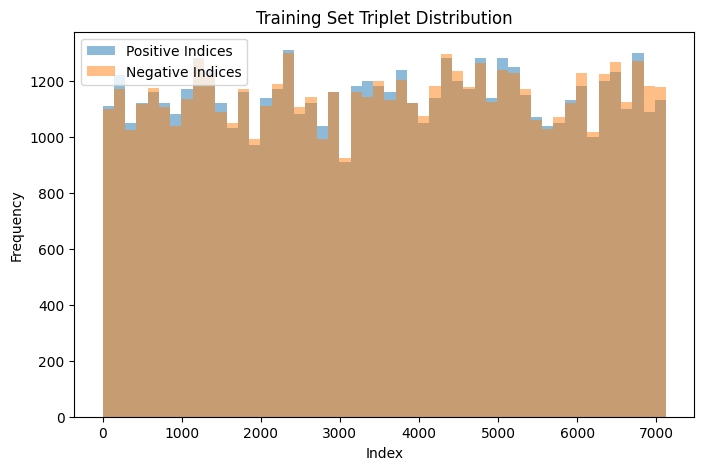

In [2]:
# Load the triplet data
with open('triplet_data/triplets_1_negatives.pickle', 'rb') as file:
    data = pickle.load(file)

# Unpack the data
audio_embeddings, audio_df, image_embeddings, image_df, triplets, triplets_train, triplets_val, triplets_test = data

# Print basic statistics about the datasets
print(f"Total triplets: {len(triplets)}")
print(f"Training triplets: {len(triplets_train)}")
print(f"Validation triplets: {len(triplets_val)}")
print(f"Test triplets: {len(triplets_test)}")

# Example of a few triplets
print("Sample triplets from the training set:")
for idx in range(5):
    print(f"Audio Index: {triplets_train[idx][0]}, Positive Image Index: {triplets_train[idx][1]}, Negative Image Index: {triplets_train[idx][2]}")

# Visualizing the balance of the dataset
def plot_triplet_distribution(triplets, title="Triplet Distribution"):
    positive_indices = [t[1] for t in triplets]
    negative_indices = [t[2] for t in triplets]

    plt.figure(figsize=(8, 5))
    plt.hist(positive_indices, alpha=0.5, label='Positive Indices', bins=50)
    plt.hist(negative_indices, alpha=0.5, label='Negative Indices', bins=50)
    plt.xlabel('Index')
    plt.ylabel('Frequency')
    plt.title(title)
    plt.legend()
    plt.show()

plot_triplet_distribution(triplets_train, "Training Set Triplet Distribution")


In [4]:
# Initialize the dataset with the training triplets
dataset = VoiceFaceDataset(audio_embeddings, image_embeddings, triplets_train)

# Show how to use the dataset
print("Sample triplets from the dataset:")
for i in range(5):
    voice, pos_face, neg_face, label = dataset[i]
    print(f"Voice Index: {triplets_train[i][0]}, Positive Face Index: {triplets_train[i][1]}, Negative Face Index: {triplets_train[i][2]}, Label: {label}")


Sample triplets from the dataset:
Voice Index: 0, Positive Face Index: 0, Negative Face Index: 1090, Label: [1.]
Voice Index: 0, Positive Face Index: 1, Negative Face Index: 6710, Label: [1.]
Voice Index: 0, Positive Face Index: 2, Negative Face Index: 6508, Label: [1.]
Voice Index: 0, Positive Face Index: 3, Negative Face Index: 6468, Label: [1.]
Voice Index: 0, Positive Face Index: 4, Negative Face Index: 4706, Label: [1.]


Saving results to folder: results
Feature batch shape: voice torch.Size([64, 192]), face torch.Size([64, 512])
Labels batch shape: torch.Size([64, 1])
[epoch 0, 1.97 sec] loss: train 0.698 val 0.695 accuracy: val 0.498 lr: 1.00e-03 
[epoch 1, 1.92 sec] loss: train 0.692 val 0.694 accuracy: val 0.503 lr: 9.95e-04 (*best validation loss*)
[epoch 2, 2.24 sec] loss: train 0.688 val 0.695 accuracy: val 0.513 lr: 9.90e-04 
[epoch 3, 2.10 sec] loss: train 0.684 val 0.691 accuracy: val 0.525 lr: 9.85e-04 (*best validation loss*)
[epoch 4, 1.93 sec] loss: train 0.672 val 0.681 accuracy: val 0.555 lr: 9.80e-04 (*best validation loss*)
[epoch 5, 1.85 sec] loss: train 0.647 val 0.638 accuracy: val 0.627 lr: 9.75e-04 (*best validation loss*)
[epoch 6, 1.93 sec] loss: train 0.604 val 0.598 accuracy: val 0.666 lr: 9.70e-04 (*best validation loss*)
[epoch 7, 2.20 sec] loss: train 0.560 val 0.574 accuracy: val 0.683 lr: 9.66e-04 (*best validation loss*)
[epoch 8, 2.13 sec] loss: train 0.523 val 0.565 a

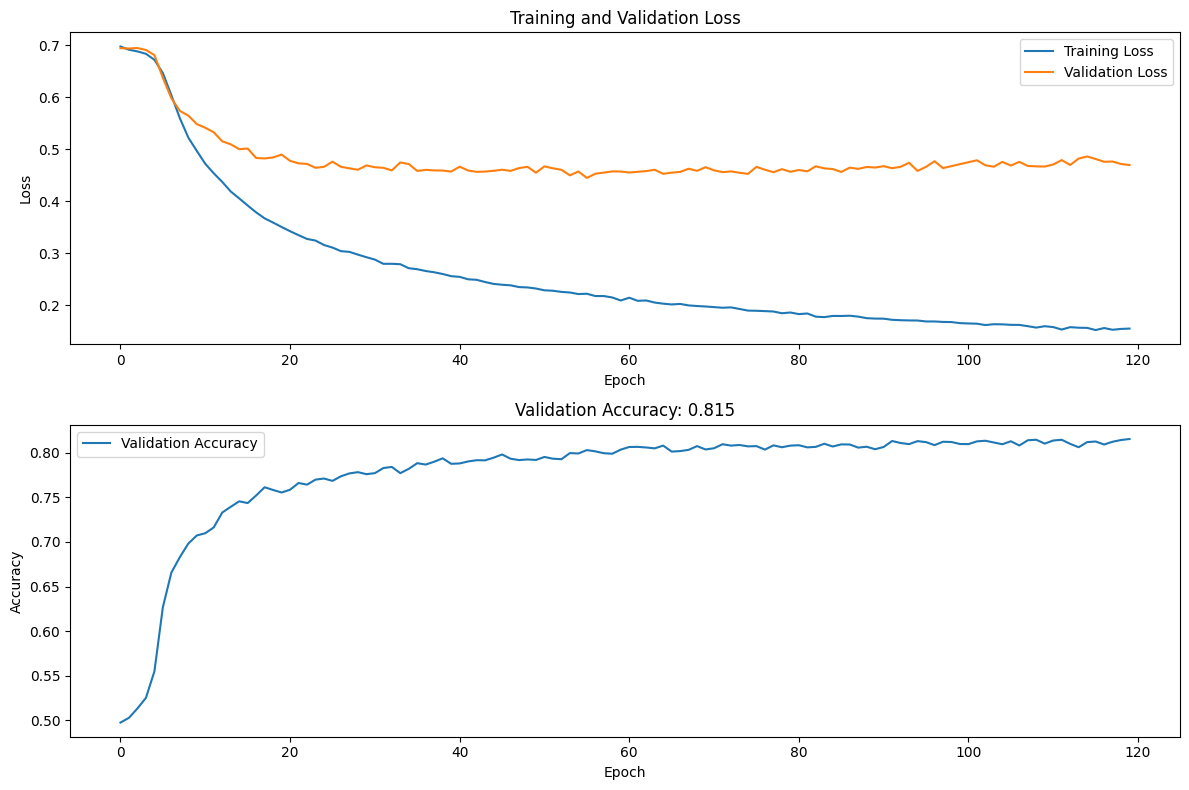

In [12]:
%run train_VFTC_model.py

In [5]:
# Running test
%run test_VFTC.py

Using CPU for evaluation.
Test Loss: 0.464
Test Accuracy: 0.822


/Users/dimarudman/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1, Loss: 0.453098516, Val Loss: 0.669808410, Val Accuracy: 51.4246%, LR: 0.0001000
Saved best model to trained_CLIP_models/best_model_epoch0.pth
Epoch 2, Loss: 0.338566443, Val Loss: 0.659608776, Val Accuracy: 51.3966%, LR: 0.0001000
Saved best model to trained_CLIP_models/best_model_epoch1.pth
Epoch 3, Loss: 0.335746732, Val Loss: 0.661910602, Val Accuracy: 51.1592%, LR: 0.0001000
Epoch 4, Loss: 0.335222345, Val Loss: 0.659972571, Val Accuracy: 51.5363%, LR: 0.0001000
Epoch 5, Loss: 0.334960773, Val Loss: 0.657683215, Val Accuracy: 50.9497%, LR: 0.0001000
Saved best model to trained_CLIP_models/best_model_epoch4.pth
Epoch 6, Loss: 0.334930264, Val Loss: 0.650763123, Val Accuracy: 50.9218%, LR: 0.0001000
Saved best model to trained_CLIP_models/best_model_epoch5.pth
Epoch 7, Loss: 0.334816673, Val Loss: 0.648304616, Val Accuracy: 51.9553%, LR: 0.0001000
Saved best model to trained_CLIP_models/best_model_epoch6.pth
Epoch 8, Loss: 0.334751634, Val Loss: 0.640865086, Val Accuracy: 52

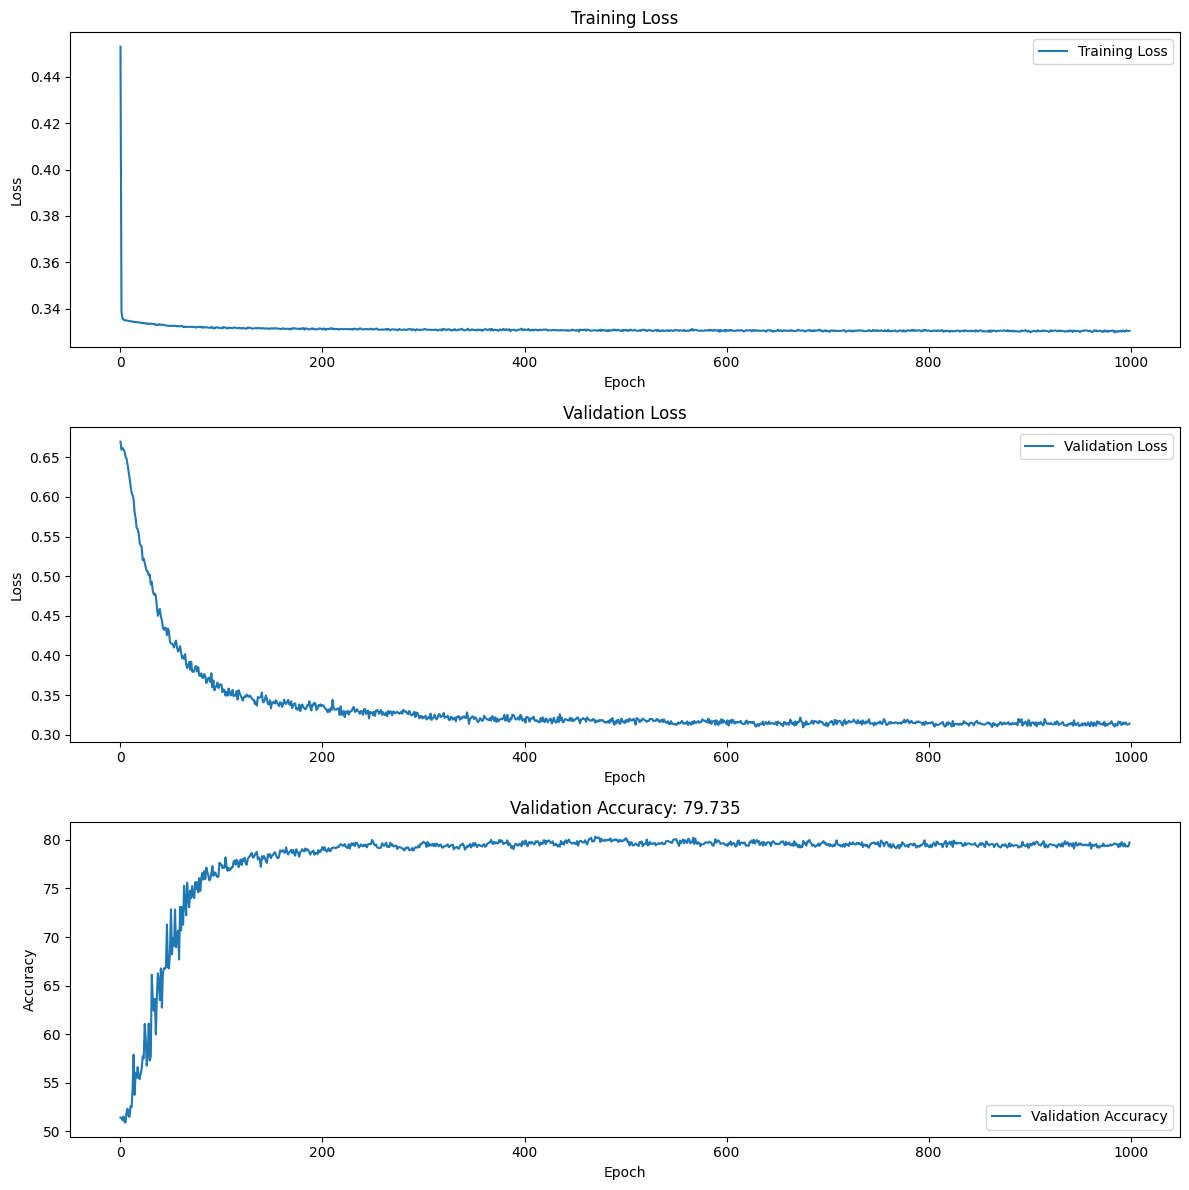

In [6]:
%run train_CLIP_model.py


In [9]:
%run test_CLIP.py

Identification Accuracy: 80.04%


Selected faces: dict_keys(['Jeffrey_Wright', 'Doutzen_Kroes', 'Vlad_Filat', 'Rachel_Griffiths', 'Shailene_Woodley', 'Rozanna_Purcell'])
Ground truth: The selected voice embedding corresponds to Jeffrey_Wright
Ranked list of faces based on similarity to the voice embedding:
Rank 1: Jeffrey_Wright with similarity 0.8781
Rank 2: Vlad_Filat with similarity 0.7514
Rank 3: Rachel_Griffiths with similarity 0.3737
Rank 4: Doutzen_Kroes with similarity 0.3699
Rank 5: Rozanna_Purcell with similarity 0.3695
Rank 6: Shailene_Woodley with similarity 0.3690


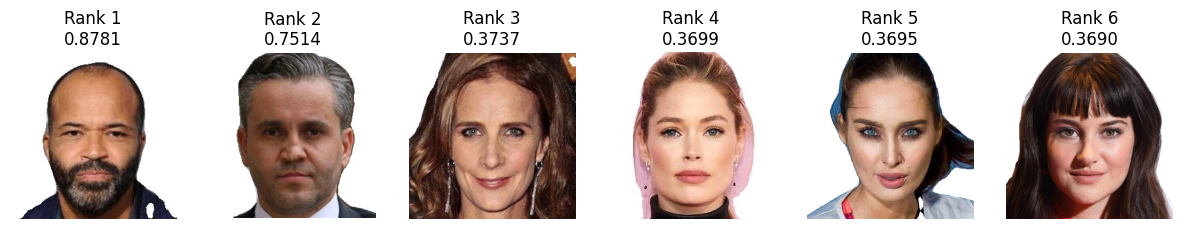

In [7]:
%run ranked_list.py